In [1]:
from astropy.io import fits
from astropy.stats import sigma_clip
import numpy as np
from matplotlib import pyplot as plt
from glob import glob
import seaborn as sns
from scipy import stats
import matplotlib.mlab as mlab
import pandas as pd
from scipy.optimize import curve_fit

%matplotlib inline
sns.set()

## Loading Fits Files

### Darks

In [2]:
DarkTempFiles = glob('SecondAttempt/Darks/DarkTemps/Darks*') 
stdArray = []
Darks = {} #10s Darks taken at various temperatures. From 19.7 to -12 degrees celsius
for file in DarkTempFiles: # loop through the list of files in the directory
    sample = fits.open(file)[0]
    temp = sample.header['CCD-TEMP']
    counts = np.mean(sample.data)
    Darks[temp] = counts # load the temperatures and corresponding mean counts into a dictionary
    stdArray.append(sample.data.std()) 

In [3]:
AmbientDarkFiles = glob('SecondAttempt/Darks/Darks-195/Darks*')

errorArray = []
AmbientDarks = {}
for i in AmbientDarkFiles:
    sample = fits.open(i)[0]
    time = sample.header['EXPTIME']
    counts = np.mean(sample.data)
    AmbientDarks[time] = counts
    errorArray.append(sample.data.std())

AmbientDarkValues = sorted(AmbientDarks.values())
AmbientDarkTimes = ['1s','10s','100s','1000s']
AmbientDarkIntegers = np.array([1,10,100,1000])
AmbientDarkStds = np.array(errorArray)
AmbientDarkStds
# Creates a dictionary of the mean counts for dark images taken at 1, 10, 100 and 1000s at ambient Temp (19.7)

array([], dtype=float64)

In [8]:
OptimumDarkFiles = glob('SecondAttempt/Darks/Darks-115/-115Darks*')

OptimumDarks = {10:[], 30:[], 50:[], 100:[]}

for j in OptimumDarkFiles:
    sample = fits.open(j)[0]
    counts = np.mean(sample.data)
    OptimumDarks[round(sample.header['EXPTIME'])].append(counts)    
        
OptimumDarkValues = np.array([np.mean(OptimumDarks[10]),np.mean(OptimumDarks[30]),np.mean(OptimumDarks[50]),np.mean(OptimumDarks[100])])
OptimumDarkTimes = np.array([10,30,50,100])
OptimumDarksStds = np.array([np.std(OptimumDarks[10])/np.sqrt(10),np.std(OptimumDarks[30])/np.sqrt(10),np.std(OptimumDarks[50])/np.sqrt(10),np.std(OptimumDarks[100])/np.sqrt(10)])
# Creates a dictionary with the mean counts for each exposure time for multiple runs. Run at -11.5 degrees

### Bias

In [9]:
BiasFiles = glob('SecondAttempt/Bias/NotBinned/Bias*')
Bias = []
for k in BiasFiles:
    sample = fits.open(k)[0]
    Bias.append(np.mean(sample.data))

Bias= np.array(Bias)

# Creating an array of all the Bias readings. 10 readings at 0.001 s exposure time

### Flats

In [10]:
FlatsFiles = glob('SecondAttempt/Flats/NotBinned/Bias*')

Flats= {1:[], 10:[], 20:[], 100:[]}
for m in FlatsFiles:
    sample = fits.open(m)[0]
    counts = np.mean(sample.data)
    Flats[round(sample.header['EXPTIME'])].append(counts)
    
# 10 (5 for 100s) readings were taken for flats at 03.51 mA, at different exposure times (1, 10, 20, 100s)
# In the Flats dictionary the keys are the times, while the values are lists of the average corresponding counts 

# look the counts it was decided an exposure time of 20 s was appropriate for the amount of light

## Data Analysis

### Darks

In [11]:
# Plotting the Dark readings as a function of temperature. Each taken at a 10s exposure time
temps = list(Darks.keys())
counts = list(Darks.values())

def exponential(x,a,b): # fitting an exponential function to the data
    return (a)*np.exp(-b*x) + 259
graphx = np.linspace(-12,20,1000)

poptDark, pcovDark = curve_fit(exponential, temps, counts, p0=[6,-0.14], sigma = stdArray, absolute_sigma=True)
expFit = exponential(graphx,*poptDark)

plt.plot(temps,counts, 'mo', label ='Experimental Data')
plt.plot(graphx,expFit,label='Best fit')
plt.errorbar(temps,counts, yerr = stdArray, fmt = '.',label=r'Standard Deviation ($\sigma$)')
plt.title('Mean Pixel Counts vs Temperature')
plt.ylabel('Average No. of Counts')
plt.xlabel(r'Temperatures ($\degree$C)')
plt.legend(loc='upper left');
# From this it was decided that the opitmum temperature to work with was -10.5 degrees Celsius 

ValueError: `ydata` must not be empty!

In [12]:
# Producing an image of the dark image at -10.5 degrees a
name1 = None
for a in DarkTempFiles:
    sample = fits.open(a)[0]
    if sample.header['CCD-TEMP']== -10.6:
        name1 = a
data = fits.open(name1)[0].data
plt.imshow(data, vmin= 250, vmax=370)
plt.colorbar()
plt.title(r'-10.5 $\degree$ C Dark Frame');

ValueError: Empty filename: None

In [13]:
# Plotting the dark current as a function of exposure time at the optimum temperature
def line(x,m,c):
    return (m*x) +c

popt, pcov = curve_fit(line, OptimumDarkTimes, OptimumDarkValues, p0=[0.004,259.4], absolute_sigma=True)
optimumFit = line(OptimumDarkTimes,*popt)

plt.plot(OptimumDarkTimes,OptimumDarkValues,'bo', label ='Experimental Data')
#plt.plot(OptimumDarkTimes,line(OptimumDarkTimes,0.004,259.4),'m-')
plt.plot(OptimumDarkTimes,optimumFit,'m-',label='Line of Best Fit')
plt.xlabel('Exposure Times')
plt.ylabel('Average Counts per Image')
plt.title('Optimum Dark Counts vs Exposure Time')
plt.legend();

print(f'The slope corresponding to optimum current per second is {round(popt[0],3)} +/- {round(np.sqrt(pcov[0,0]),3)} mA/s')

ValueError: array must not contain infs or NaNs

In [14]:
# Producing an image of the dark image at ambient temp
name2 = DarkTempFiles[-5]
ambientImage = fits.open(name2)[0].data
plt.imshow(ambientImage, vmin= 250, vmax=600)
plt.colorbar()
plt.title(r'19.7 $\degree$ C Dark Frame');

IndexError: list index out of range

In [15]:

popt1, pcov1 = curve_fit(line, AmbientDarkIntegers, AmbientDarkValues, p0=[0.04,340], absolute_sigma=True)
ambientFit = line(AmbientDarkIntegers,*popt1)

plt.plot(AmbientDarkIntegers,AmbientDarkValues,'bo',label='Experimental Data')
#plt.plot(AmbientDarkIntegers,line(AmbientDarkIntegers,0.04,350))

plt.plot(AmbientDarkIntegers,ambientFit,'m-',label='Line of Best Fit')
plt.xlabel('Exposure Times')
plt.ylabel('Average Image Counts')
plt.title('Ambient Dark Counts vs Exposure Time')
plt.legend();

print(f'The slope corresponding to dark current per second is {round(popt1[0],3)} +/- {round(np.sqrt(pcov1[0,0]),3)} mA/s')

ValueError: `ydata` must not be empty!

### Biases

(260.28411, 4.31369128565084)

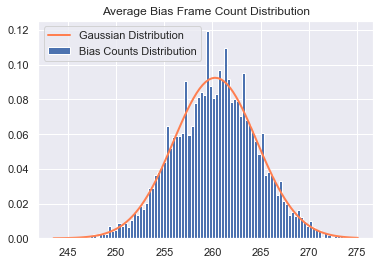

In [12]:
MasterBiasImage = np.zeros([1039,1391])
for i in BiasFiles:
    file = fits.open(i)[0].data
    MasterBiasImage+= file
mBiasCounts = np.ravel((MasterBiasImage/len(BiasFiles))[646:746,470:570])

n,bins,patches = plt.hist(mBiasCounts,bins=100,density=1,label='Bias Counts Distribution')
bias_mu, bias_sigma = stats.norm.fit(mBiasCounts)
fitFunc = stats.norm.pdf(bins,bias_mu,bias_sigma)
plt.plot(bins,fitFunc,color='coral',linewidth=2, label ='Gaussian Distribution')
plt.title('Average Bias Frame Count Distribution')
plt.legend();

# A normally calculated Masterbias shows that the counts follow a normal gaussian distribution (in a 100x100 region)
# From this we can use sigma clipping to remove outliers from the data, if needed.
bias_mu, bias_sigma,

In [13]:
def createMasterBias(directory):
    aListOfImages = []# create an empty list to store the images
    emptyImage = []
    for i in directory:
        image = fits.open(i)[0].data # loop through the files in the directroy, extract data and add to list
        aListOfImages.append(image)

    anArrayOfImages = np.array(aListOfImages) # converting to an array
    rearrangedArray = np.swapaxes(anArrayOfImages,0,2) # rearranging array so it can be concatenated
    allTheValues = np.concatenate(rearrangedArray) # creating an array with every pixel and its following 10 values
    j = 0 
    while j < len(allTheValues):
        #clipped = sigma_clip(allTheValues[j],sigma=1,maxiters=None,cenfunc='median', masked=False) # sigma clipping each pixel
        #averagedValues = np.mean(clipped) #averaging each clip
        averagedValues = np.mean(allTheValues[j])
        emptyImage.append(averagedValues)
        j+=1
    emptyImage = np.array(emptyImage)
    masterImage = emptyImage.reshape(1039,1391) #rearranging back into image form
    return masterImage

bigMasterBias = createMasterBias(BiasFiles)

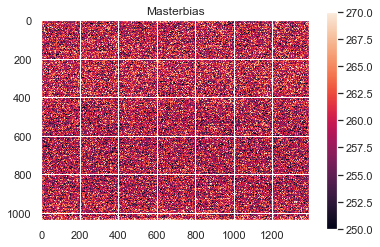

In [14]:
otherImage = bigMasterBias/np.mean(bigMasterBias)
plt.imshow(bigMasterBias,vmin=250, vmax= 270)
plt.colorbar();
plt.title('Masterbias');


### Flats

Checking that no pixels are saturated. Saturated pixel count = 7 
 The average count from the flat field is 60316.86754787583 with a standard deviation of 1737.9839798636597


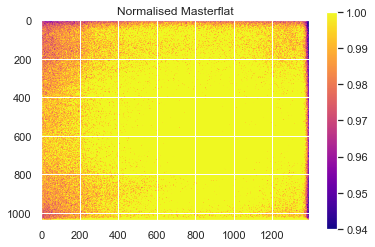

In [15]:
Flats20s = np.zeros([1039,1391])
usedFlats = glob('SecondAttempt/Flats/NotBinned/20s/Bias*')

for file in usedFlats:
    sample = fits.open(file)[0]
    if sample.header['EXPTIME'] == 20.001:
        Flats20s += (sample.data) # subtracting each 

MasterFlatImage = Flats20s/10 # Masterflat 
print(f'Checking that no pixels are saturated. Saturated pixel count = {np.count_nonzero(MasterFlatImage>=65535)} ')
print(f' The average count from the flat field is {MasterFlatImage.mean()} with a standard deviation of {MasterFlatImage.std()}')

newImage = MasterFlatImage/np.mean(MasterFlatImage)
plt.imshow(newImage, cmap= 'plasma',vmin = 0.94, vmax=1) 
plt.colorbar()
plt.title('Normalised Masterflat');

(60763.792310000004, 284.5184678713561, 59667.0, 61806.4)

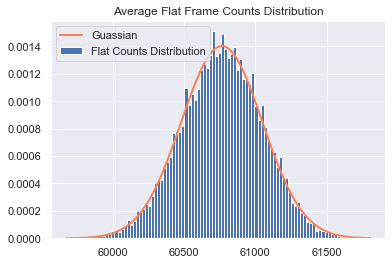

In [16]:
mFlatCounts = np.ravel(MasterFlatImage[646:746,470:570])

n,bins,patches = plt.hist(mFlatCounts,bins=100,density=1,label = 'Flat Counts Distribution')
flat_mu, flat_sigma = stats.norm.fit(mFlatCounts)
fitFunc = stats.norm.pdf(bins,flat_mu,flat_sigma)
plt.plot(bins,fitFunc,color='coral',linewidth=2,label = 'Guassian')
plt.title('Average Flat Frame Counts Distribution')
plt.legend();

flat_mu, flat_sigma, mFlatCounts.min(), mFlatCounts.max()

In [17]:
#So we have an image of 1039x1391 pixels. That's a total of 1445249. As above, we can consider the distrubtion of 
# counts to follow that of a Guassian. In order to determine how much / if the data needs to be clipped by 
# I'll look at the standard deviations to determine how many outliers would be expected and compare to the data

pixelNum = len(mFlatCounts)

# The function calculates how many points are outside a range for a standard distributiona and against the acutal 
# results. If the actual data returns a similar value there shouldn't be a need to sigma clip.

def howManyOutside(data,mean,std,var,num):
    expected = 2*(1-stats.norm.cdf(var))*(num)
    actual = np.count_nonzero(data>= (mean+var*std)) + np.count_nonzero(data<= (mean-var*std))
    return (expected,actual)

howManyOutside(mFlatCounts,flat_mu,flat_sigma,3,pixelNum)

#howManyOutside(mBiasCounts,bias_mu,bias_sigma,3,len(mBiasCounts))

(26.99796063260207, 26)

By examining 100x100 pixel regions in simply calculated masterbias and masterflat images it is seen that the counts follow a gaussian distribution. Using the cumulutive distribution function in howManyOutside, the amount of points that fall outside 3 sigma are compared to how many would be expected in a guassian distribution. The results show that the true number of counts is approximately equal to that predicted by a guassian, and hence it can be concluded that there is no need for sigma clipping. 

In [67]:
flats_20s = glob('SecondAttempt/Flats/NotBinned/20s/Bias*')
def createMasterFlat(directory,biasImage):
    aListOfImages = []# create an empty list to store the images
    emptyImage = []
    for i in directory:
        image = fits.open(i)[0].data # loop through the files in the directroy, extract data and add to list
        aListOfImages.append(image-biasImage)

    anArrayOfImages = np.array(aListOfImages) # converting to an array
    rearrangedArray = np.swapaxes(anArrayOfImages,0,2) # rearranging array so it can be concatenated
    allTheValues = np.concatenate(rearrangedArray) # creating an array with every pixel and its following 10 values
    j = 0 
    while j < len(allTheValues):
        #clipped = sigma_clip(allTheValues[j],sigma=2.5,maxiters=None,cenfunc='median', masked=False) # sigma clipping each pixel
        #averagedValues = np.average(clipped) #averaging each clip
        averagedValues = np.average(allTheValues[j])
        emptyImage.append(averagedValues)
        j+=1
    emptyImage = np.array(emptyImage)
    masterImage = emptyImage.reshape(1039,1391) #rearranging back into image form
    return masterImage

bigMasterFlat = createMasterFlat(flats_20s,bigMasterBias.astype(float)) # Sigma Clipped masterflat

## Gain and Readnoise

In [18]:
biasOne = fits.open(BiasFiles[2])[0].data[646:746, 470:570].astype(float) # astype(float) to avoid utype 16 error

biasTwo = fits.open(BiasFiles[5])[0].data[646:746, 470:570].astype(float)

flatOne = fits.open(FlatsFiles[3])[0].data[646:746, 470:570].astype(float) - biasOne

flatTwo = fits.open(FlatsFiles[4])[0].data[646:746, 470:570].astype(float) - biasTwo

def corrections(flat1,flat2,bias1,bias2): # function that calculates the gain and readout noise
    flatDiff = np.abs(flat1-flat2)
    biasDiff = bias1-bias2
    numerator = (flat1.mean()+flat2.mean()) -(bias1.mean()+bias2.mean())
    denominator = ((flatDiff.std())**2) - ((biasDiff.std())**2)
    gain = numerator/denominator
    readnoise = gain*((biasDiff.std())/np.sqrt(2))
    return gain, readnoise

doTheMaths = corrections(flatOne,flatTwo,biasOne,biasTwo)
print(f'Gain is calculated to be {doTheMaths[0]:.3e} with readnoise {doTheMaths[1]:.3e}')

Gain is calculated to be 2.471e-01 with readnoise 3.341e+00


In [19]:

biasOneError = biasOne.std()/np.sqrt(len(biasOne)) # error taken to be the standard error of the mean for each image

biasTwoError = biasTwo.std()/np.sqrt(len(biasTwo))

flatOneError = flatOne.std()/np.sqrt(len(flatOne))

flatTwoError = flatTwo.std()/np.sqrt(len(flatTwo))


In [22]:
def errorOnGain(f1,f1_err,f2,f2_err,b1,b1_err,b2,b2_err): #errors on gain, determiend by propagation of errors formula
    flatDiffSigma = (f1 - f2).std()
    biasDiffSigma = (b1-b2).std()
    dgdf = 1/((flatDiffSigma**2) - (biasDiffSigma**2))
    dgdb = -1/((flatDiffSigma**2) - (biasDiffSigma**2))
    
    firstHalf = (f1_err**2)*(dgdf**2) + (f2_err**2)*(dgdf**2)
    secondHalf = (b1_err**2)*(dgdb**2) + (b2_err**2)*(dgdb**2)
    return np.sqrt(firstHalf+secondHalf)

def errorOnReadnoise(b1,b2,g_err): # error on readout noise, also determined by propagation of errors formula
    biasDiff = b1-b2
    biasDiffSigma = biasDiff.std()
    return (g_err)*(biasDiffSigma/np.sqrt(2))

gainError = errorOnGain(flatOne,flatOneError,flatTwo,flatTwoError,biasOne,biasOneError,biasTwo,biasTwoError)
readnoiseError = errorOnReadnoise(biasOne,biasTwo,gainError)

## Persistance Effects

In [23]:
PersistanceFiles2 = glob('SecondAttempt/Flats/PersistanceEffects/Method2/*')
persistance = {3:[], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[],10:[]} #dictionary with times as keys and values as averae counts
for i in range(3,11): # filling in dictionary
    averageImage = np.zeros([1039,1391])
    for file in glob(f'SecondAttempt/Flats/PersistanceEffects/Method2/{i}s/*'):
        sample = np.mean(fits.open(file)[0].data)
        averageImage += sample
    newImage = averageImage/3
    avgValue = np.mean(newImage)
    persistance[i].append(avgValue)
persistance[2]= np.mean(fits.open(PersistanceFiles2[6])[0].data)
for i in persistance:
    persistance[i]= np.mean(persistance[i])
persistance

{3: 61405.608381669954,
 4: 53215.26788094433,
 5: 45384.58905351256,
 6: 33926.13005602019,
 7: 22980.81829428708,
 8: 12102.183436902531,
 9: 23237.23228569376,
 10: 13293.256460305469,
 2: 65488.09919190396}

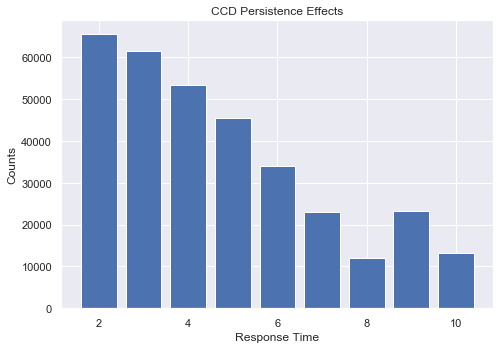

([3, 4, 5, 6, 7, 8, 9, 10, 2],
 array([61405.60838167, 53215.26788094, 45384.58905351, 33926.13005602,
        22980.81829429, 12102.1834369 , 23237.23228569, 13293.25646031,
        65488.0991919 ]))

In [24]:
persistanceXs = list(persistance.keys())  
persistanceYs =np.array(list(persistance.values()))

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(persistanceXs,persistanceYs)
ax.set_title('CCD Persistence Effects')
ax.set_ylabel('Counts')
ax.set_xlabel('Response Time')
plt.show();
persistanceXs, persistanceYs
#Plotting histogram of persistence effects